# Calculate Lagged correlation and Granger causality
This notebook calculates the lagged correlation and Granger causality for the input data. It exports them to Data folder, which can be used in the other notebooks.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import numpy as np
import pyunicorn.timeseries.surrogates as pysurrogates
from tqdm.auto import tqdm

import scipy.stats as stats
from scipy.stats import norm

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import bgzf;
import struct;


nx = 288
ny = 140
# nx = 36
# ny = 14
smoothWindowSize = 7
lagDays=90
dataRange = (0,100) #percentage

%config InlineBackend.figure_format = 'retina'

In [3]:
#Load files in the bgz format (see ParseData to adapt it to use your own data)
def loadCompressedClimateData():
    with bgzf.open("../Data/climateData.bgz","rb") as fd:
        data = fd.read(8*2);
        gridCount,seriesSize = struct.unpack("<QQ",data);
        latitudes = np.zeros(gridCount,dtype=np.float32);
        longitudes = np.zeros(gridCount,dtype=np.float32);
        temperatures = np.zeros((gridCount,seriesSize),dtype=np.float32);
        preciptations = np.zeros((gridCount,seriesSize),dtype=np.float32);
        for i in range(gridCount):
            data = fd.read(4*2);
            lat,lon = struct.unpack("<ff",data);
            latitudes[i] = lat;
            longitudes[i] = lon;
            data = fd.read(4*seriesSize);
            temperatures[i,:] = struct.unpack("<%df"%seriesSize,data);
            data = fd.read(4*seriesSize);
            preciptations[i,:] = struct.unpack("<%df"%seriesSize,data);
    return latitudes,longitudes,temperatures,preciptations

In [4]:
#Loading data from the bgz file
latitudes,longitudes,temperaturesOrig,preciptationsOrig = loadCompressedClimateData();

In [5]:
%load_ext Cython

In [6]:
%%cython
#%%cython --annotate
# distutils: extra_compile_args=-fopenmp -O3
# distutils: extra_link_args=-fopenmp -O3

import numpy as np
cimport cython
from cython.parallel import prange
from libc.math cimport sqrt
from libc.math cimport fabs

ctypedef fused aNumber:
    float
    double
    
# Function to mask regions
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def maskForRegion(aNumber[:] boundingBox, aNumber[:] longitudes, aNumber[:] latitudes):
    mask = [];
    cdef Py_ssize_t pointCount;
    pointCount = len(latitudes);
    for i in range(pointCount):
        if((boundingBox[0]==boundingBox[1] or (latitudes[i] < boundingBox[1] and latitudes[i] > boundingBox[0])) \
            and (boundingBox[2]==boundingBox[3] or (longitudes[i] < boundingBox[3] and longitudes[i] > boundingBox[2]))):
            mask.append(i);
    return np.array(mask);

In [7]:
%%cython
#--annotate
# %%cython
# distutils: extra_compile_args=-fopenmp -O3
# distutils: extra_link_args=-fopenmp -O3



#### A-cython: profile=True
#### A-cython: linetrace=True
#### A-cython: binding=True
#### A-distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
cimport cython
from cython.parallel import prange
from libc.math cimport sqrt
from libc.math cimport fabs

import pyunicorn.timeseries.surrogates as pysurrogates

ctypedef fused aNumber:
    float
    double


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef aNumber computeAverageTo(aNumber[:, ::1] data, Py_ssize_t entryIndex, Py_ssize_t featuresCount) nogil:
    cdef aNumber average;
    cdef Py_ssize_t featureIndex;
    average=0;
    for featureIndex in range(featuresCount):
        average+=data[entryIndex,featureIndex];
    return average/featuresCount;

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef aNumber computeStdDevTo(aNumber[:, ::1] data, aNumber average,Py_ssize_t entryIndex, Py_ssize_t featuresCount) nogil:
    cdef aNumber stddev;
    cdef Py_ssize_t featureIndex;
    cdef aNumber value;
    stddev=0;
    for featureIndex in range(featuresCount):
        value = data[entryIndex,featureIndex]-average;
        stddev+=value**2;
    return sqrt(stddev/featuresCount);


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef aNumber computeAverageFrom(aNumber[:] data, Py_ssize_t featuresCount) nogil:
    cdef aNumber average;
    cdef Py_ssize_t featureIndex;
    average=0;
    for featureIndex in range(featuresCount):
        average+=data[featureIndex];
    return average/featuresCount;

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cdef aNumber computeStdDevFrom(aNumber[:] data, aNumber average, Py_ssize_t featuresCount) nogil:
    cdef aNumber stddev;
    cdef Py_ssize_t featureIndex;
    cdef aNumber value;
    stddev=0;
    for featureIndex in range(featuresCount):
        value = data[featureIndex]-average;
        stddev+=value**2;
    return sqrt(stddev/featuresCount);



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def computeLagCorrelations(aNumber[:] dataFrom, aNumber[:, ::1] dataTo, Py_ssize_t maxLag):
    cdef Py_ssize_t entriesToCount = dataTo.shape[0]
    cdef Py_ssize_t start = maxLag
    cdef Py_ssize_t w = dataFrom.shape[0]-start
    
    
    assert dataTo.shape[1] == dataFrom.shape[0]
    
    if aNumber is double:
        dtype = np.double
    elif aNumber is float:
        dtype = np.float
    
    correlations = np.zeros(entriesToCount, dtype=dtype)
    lags = np.zeros(entriesToCount, dtype=np.intc)
    
    cdef aNumber[:] correlations_view = correlations
    cdef int[:] lags_view = lags

    cdef aNumber fromAverage # = np.average(dataFrom[:w]);
    cdef aNumber fromStdDev # = np.std(dataFrom[:w]);
    
    cdef aNumber toAverage
    cdef aNumber toStdDev
    cdef Py_ssize_t toIndex
    
    cdef int lag
    
    
    cdef int featureIndex
    cdef aNumber correlation
    cdef aNumber maxCorrelation
    cdef int lagMax
    
    for toIndex in prange(entriesToCount, nogil=True):#
        maxCorrelation=0;
        lagMax=0;
        toAverage = computeAverageTo(dataTo[:,(start):],toIndex, w);
        toStdDev = computeStdDevTo(dataTo[:,(start):],toAverage,toIndex,w);

        for lag in range(maxLag+1):
            fromAverage = computeAverageFrom(dataFrom[(start-lag):], w);
            fromStdDev = computeStdDevFrom(dataFrom[(start-lag):],fromAverage,w);
            correlation = 0
            for featureIndex in range(w):
                correlation = correlation + (dataFrom[featureIndex+start-lag]-fromAverage)*(dataTo[toIndex,featureIndex+(start)]-toAverage);
            correlation = correlation/toStdDev/fromStdDev/w;
#             print((fromAverage,toAverage,fromStdDev,toStdDev,w,correlation))
    #                 print("[%d,%d] %d:%.2f (max:%.2f)"%(fromIndex,toIndex,lag,correlation,maxCorrelation));
            if(fabs(maxCorrelation)<fabs(correlation)):
                maxCorrelation=correlation;
                lagMax=lag;

        correlations_view[toIndex] = maxCorrelation;
        lags_view[toIndex] = lagMax;

    return (correlations,lags)



#Compute Lag Correlation
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def computeLagCorrelations(aNumber[:] dataFrom, aNumber[:, ::1] dataTo, Py_ssize_t maxLag):
    cdef Py_ssize_t entriesToCount = dataTo.shape[0]
    cdef Py_ssize_t start = maxLag
    cdef Py_ssize_t w = dataFrom.shape[0]-start
    
    
    assert dataTo.shape[1] == dataFrom.shape[0]
    
    if aNumber is double:
        dtype = np.double
    elif aNumber is float:
        dtype = np.float
    
    correlations = np.zeros(entriesToCount, dtype=dtype)
    lags = np.zeros(entriesToCount, dtype=np.intc)
    
    cdef aNumber[:] correlations_view = correlations
    cdef int[:] lags_view = lags

    cdef aNumber fromAverage # = np.average(dataFrom[:w]);
    cdef aNumber fromStdDev # = np.std(dataFrom[:w]);
    
    cdef aNumber toAverage
    cdef aNumber toStdDev
    cdef Py_ssize_t toIndex
    
    cdef int lag
    
    
    cdef int featureIndex
    cdef aNumber correlation
    cdef aNumber maxCorrelation
    cdef int lagMax
    
    for toIndex in prange(entriesToCount, nogil=True):#
        maxCorrelation=0;
        lagMax=0;
        toAverage = computeAverageTo(dataTo[:,(start):],toIndex, w);
        toStdDev = computeStdDevTo(dataTo[:,(start):],toAverage,toIndex,w);

        for lag in range(maxLag+1):
            fromAverage = computeAverageFrom(dataFrom[(start-lag):], w);
            fromStdDev = computeStdDevFrom(dataFrom[(start-lag):],fromAverage,w);
            correlation = 0
            for featureIndex in range(w):
                correlation = correlation + (dataFrom[featureIndex+start-lag]-fromAverage)*(dataTo[toIndex,featureIndex+(start)]-toAverage);
            correlation = correlation/toStdDev/fromStdDev/w;
#             print((fromAverage,toAverage,fromStdDev,toStdDev,w,correlation))
    #                 print("[%d,%d] %d:%.2f (max:%.2f)"%(fromIndex,toIndex,lag,correlation,maxCorrelation));
            if(fabs(maxCorrelation)<fabs(correlation)):
                maxCorrelation=correlation;
                lagMax=lag;

        correlations_view[toIndex] = maxCorrelation;
        lags_view[toIndex] = lagMax;

    return (correlations,lags)


In [8]:
#Utility functions
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def averageTimeseriesForRegions(regions,timeSeries,longitudes,latitudes,w=0,):
    averageSeries = [];
    errorSeries = [];
    for region in tqdm(regions):
        mask = maskForRegion(np.array(region,dtype=np.float),longitudes,latitudes);
#         print(len(mask))
        averageEntry = np.average(timeSeries[mask],axis=0);
        errorEntry = np.std(timeSeries[mask],axis=0);
        if(w>0):
            averageEntry = moving_average(averageEntry,w);
            errorEntry = moving_average(errorEntry,w);
        averageSeries.append(averageEntry); 
        errorSeries.append(errorEntry);
    return averageSeries,errorSeries

In [9]:
def shuffleTimeSeries(inputSeries):
    a = np.array(inputSeries.T);
    np.random.shuffle(a)
    return a.T;

def calcCausalityBivariate(X, causedByIndex, causingIndex, order): #Significance level alpha is generally 0.05
    causedByIndex = causedByIndex
    causingIndex = causingIndex
    samplesCount = X.shape[0]
    dataLength = X.shape[1]

    causedNew = X[order:, causedByIndex]

    completeX = np.empty((samplesCount - order, 0))
    for lagIndex in range(order):
        completeX = np.hstack((completeX, X[lagIndex : samplesCount - order + lagIndex]))

    reducedX = np.delete(X, causingIndex, 1)

    reducedXcomplete = np.empty((samplesCount - order, 0))
    for lagIndex in range(order):
        reducedXcomplete = np.hstack((reducedXcomplete, reducedX[lagIndex : samplesCount - order + lagIndex]))

    reg = linear_model.LinearRegression()
    reg_fit = reg.fit(completeX, causedNew)

    predictedYcomplete = reg.predict(completeX)
    predictedYcomplete = predictedYcomplete
    errorComplete = causedNew - predictedYcomplete


    regressionModel = linear_model.LinearRegression()
    regressionFitReduced = regressionModel.fit(reducedXcomplete, causedNew)
    regressionReduced = regressionModel.predict(reducedXcomplete)
    errorReducedComplete = causedNew - regressionReduced

    #error complete
    residueComplete = np.sum(errorComplete**2)
    
    #reduced error
    residueReducedComplete = np.sum(errorReducedComplete**2)
    fValue = ((residueReducedComplete - residueComplete)/order) / (residueComplete / (samplesCount-order))
    
    gammaF = (order) * fValue

    pValue = stats.distributions.chi2.sf(gammaF,order)
    return fValue,pValue;


In [10]:
# Save utility functions
def saveMetricData(metric,smoothWindowSize,lagDays,pDataPValue,pDataValue):
    dataName = "%s_d%d_l%d_nx%d_ny%d_R%d-%d_v8"%(metric,smoothWindowSize,lagDays,nx,ny,dataRange[0],dataRange[1]);
    fd = open("../Data/%s.csv"%dataName,"w");
    fd.write("lat,lng,pvalue,value\n");
    for i,region in enumerate(gridRegions):
        regionPvalue = pDataPValue[i];
        regionValue = pDataValue[i];
        lat,lng = (region[0]+region[1])*0.5,(region[2]+region[3])*0.5;
        fd.write("%.20g,%.20g,%.20g,%.20g\n"%(lat,lng,regionPvalue,regionValue));
    fd.close();

<ipython-input-10-5a5e06ecdc29>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lonArray = np.array(longitudes,dtype=np.float);
<ipython-input-10-5a5e06ecdc29>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latArray = np.array(latitudes,dtype=np.float);


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-7-a75d6b933582>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = maskForRegion(np.array(region,dtype=np.float),longitudes,latitudes);


  0%|          | 0/40320 [00:00<?, ?it/s]

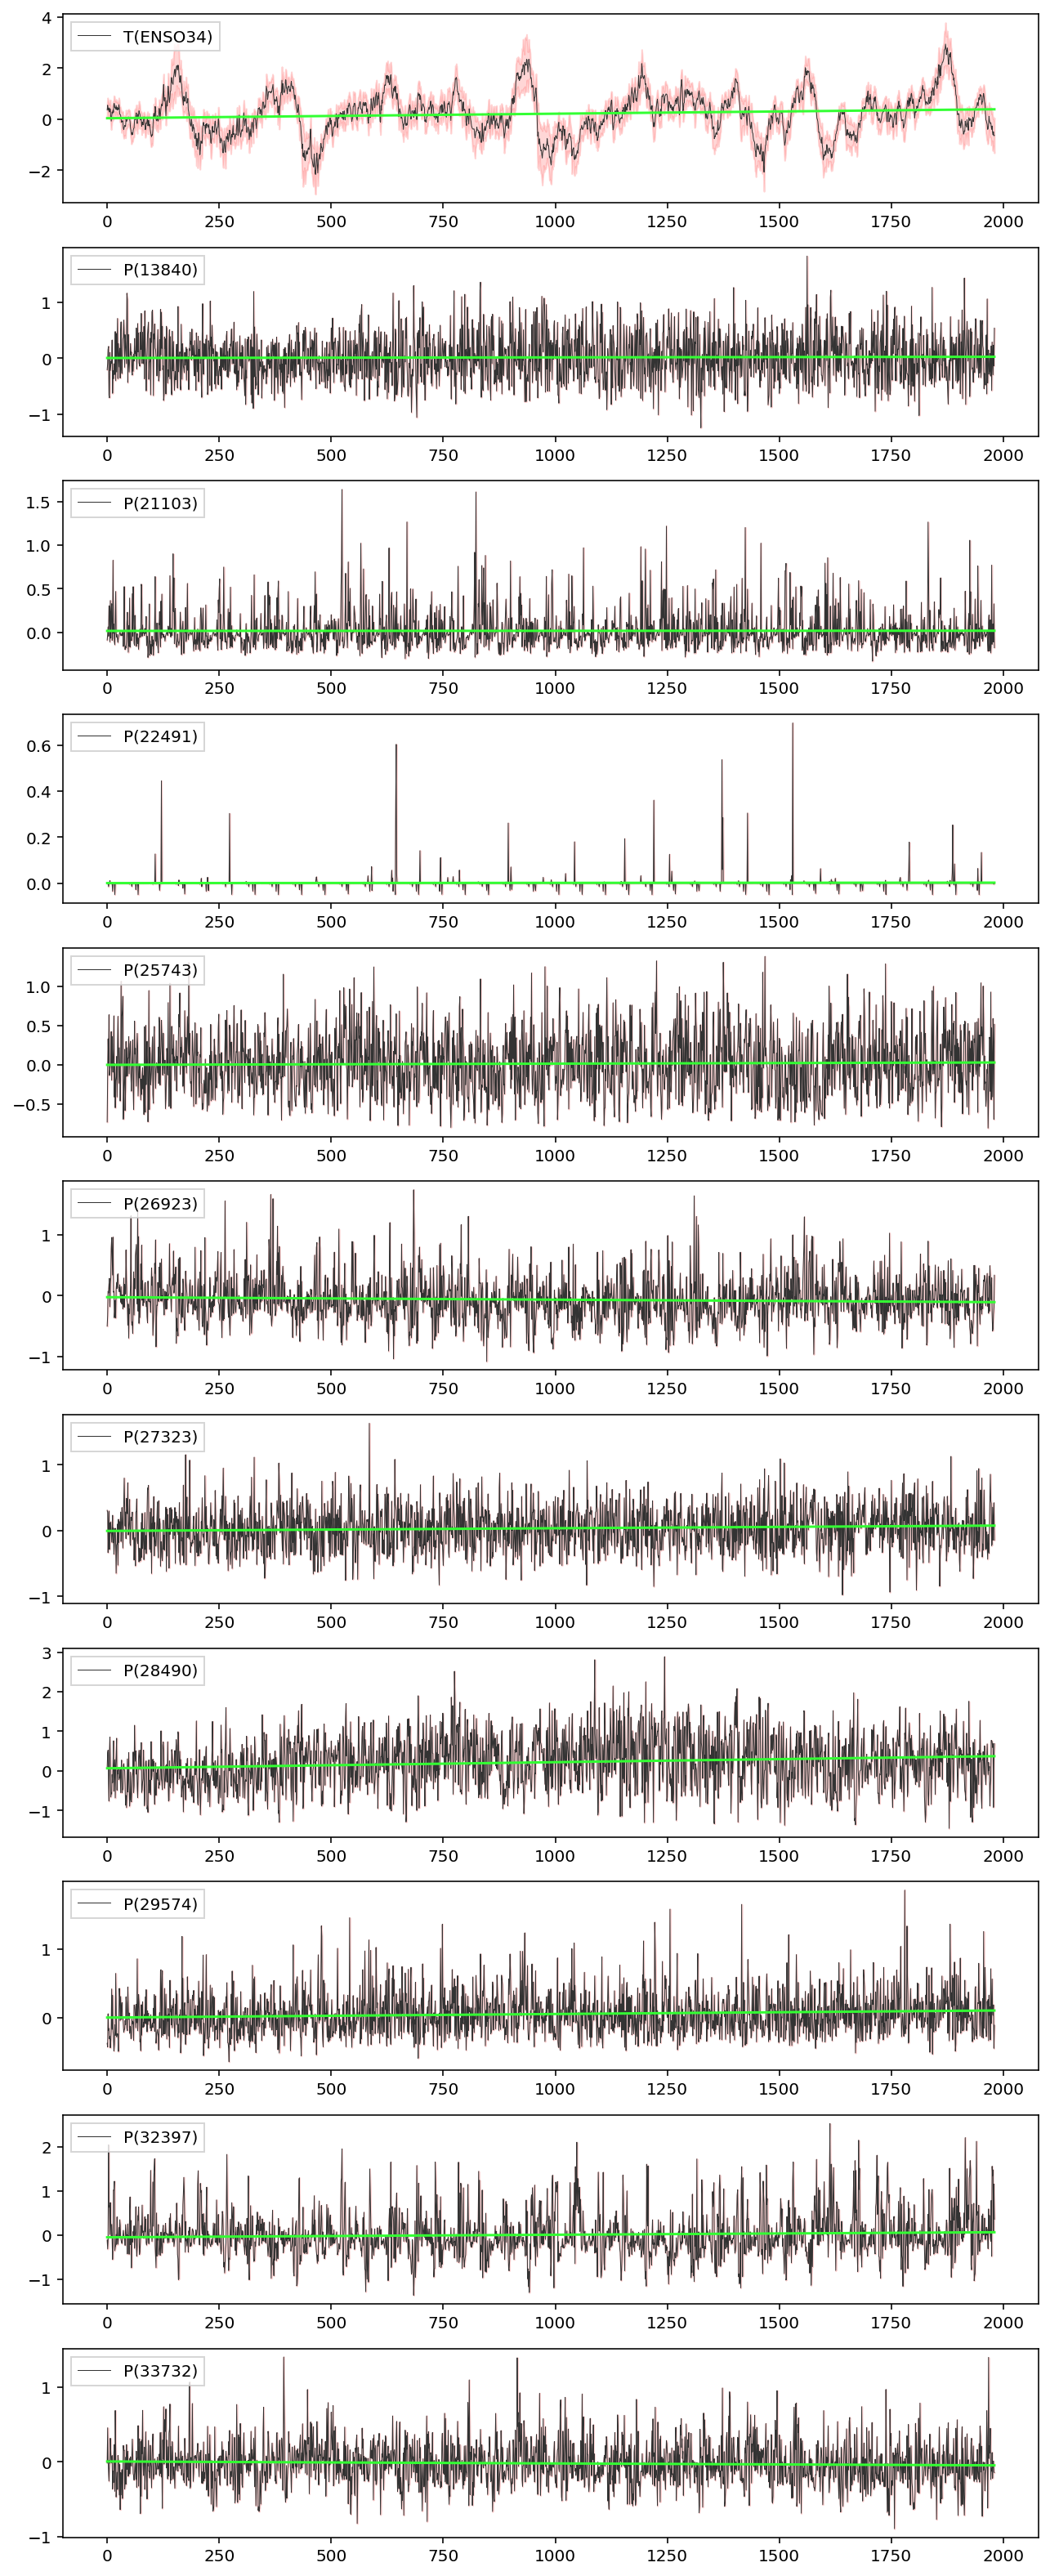

In [10]:
temperatures = temperaturesOrig[:,int(temperaturesOrig.shape[1]*dataRange[0]/100.0):int(temperaturesOrig.shape[1]*dataRange[1]/100.0)]
preciptations = preciptationsOrig[:,int(preciptationsOrig.shape[1]*dataRange[0]/100.0):int(preciptationsOrig.shape[1]*dataRange[1]/100.0)]

# Setting the ENSO Region as starting point
regions = {
   "ENSO34"     : [ -5  , 5, -170, -120],
}
fromRegionName = "ENSO34"

# Setting the window size to be 7 days
# and choosing maximum lat to 90 days
fromRegion = regions[fromRegionName]


gridRegions = [];
x = np.linspace(-180+180/(nx), 180+180/(nx), nx+1)
y = np.linspace(-70+70/(ny), 70+70/(ny), ny+1)
xv, yv = np.meshgrid(x, y,sparse=False, indexing='ij')
for xi in range(nx):
    for yi in range(ny):
        gridRegions.append([yv[xi,yi], yv[xi+1,yi+1], xv[xi,yi],xv[xi+1,yi+1]]);

lonArray = np.array(longitudes,dtype=np.float);
latArray = np.array(latitudes,dtype=np.float);
select180 = lonArray==-180;
lonArray = np.concatenate([lonArray,-lonArray[select180]])
latArray = np.concatenate([latArray,latArray[select180]])
latArray[np.abs(latArray)<10e-4] = 0
lonArray[np.abs(lonArray)<10e-4] = 0

temperaturesArray = np.concatenate([temperatures,temperatures[select180]])
preciptationsArray = np.concatenate([preciptations,preciptations[select180]])

inputTemperatures,errorsTemperatures = averageTimeseriesForRegions([fromRegion],temperaturesArray,lonArray,latArray,w=smoothWindowSize)
inputPreciptations,errorsPreciptations = averageTimeseriesForRegions(gridRegions,preciptationsArray,lonArray,latArray,w=smoothWindowSize)

seriesNames = ["T(%s)"%fromRegionName]+["P(%d)"%index for index in range(len(gridRegions))]
# seriesNames.append(seriesNames[-1]+"2")
inputSeriesOriginal = np.array(inputTemperatures+inputPreciptations)
errorSeriesOriginal = np.array(errorsTemperatures+errorsPreciptations)

seriesStart = 0
seriesEnd = 20000;
seriesStep = smoothWindowSize;
inputSeries = np.array(inputSeriesOriginal[:,seriesStart:seriesEnd:seriesStep]);
errorSeries = np.array(errorSeriesOriginal[:,seriesStart:seriesEnd:seriesStep]);

yy = inputSeries[0];
xx = np.arange(0,len(yy))
xx = np.reshape(xx, (len(xx), 1))
selectedSeries = set(np.random.choice(np.arange(len(inputSeries)),10))
fig = plt.figure(figsize=(9,2*(len(selectedSeries)+1)),tight_layout=True);

# detrending time series by using linear regression
plotIndex=0;
for i,yvalues in enumerate(inputSeries):
    xvalues = np.arange(0,len(inputSeries[i]));
    xx = np.reshape(xvalues, (len(xvalues), 1))

    model = LinearRegression()
    model.fit(xx, yvalues)
    trend = model.predict(xx)
#     model = make_pipeline(PolynomialFeatures(2), Ridge())
    if(i in selectedSeries or i==0):
        plt.subplot(len(selectedSeries)+1,1,plotIndex+1);
        plt.plot(xvalues,yvalues,label = seriesNames[i],c="#333333",linewidth=0.5);
        plt.fill_between(xvalues,inputSeries[i]-errorSeries[i],inputSeries[i]+errorSeries[i],alpha=0.2,color="#ff3333")
        plt.plot(xvalues,trend,c="#33ff33");
        plt.legend(loc=2,fancybox=False);
        plotIndex+=1;
    inputSeries[i,:] = yvalues-trend;
# plt.savefig("series.pdf")
plt.show()


In [86]:
# Calculating Granger Causality between first time series and all others
order = int(math.ceil(lagDays/seriesStep)) # Redefines max lag in terms of the chosen window size 
grangerXY = []
grangerPValuesXY = [];
for i in tqdm(range(1,len(inputSeries))):
    X = inputSeries[0];
    Y = inputSeries[i];
    grangerValue,pValue = calcCausalityBivariate(np.array([X,Y]).T, 1, 0, order);
    grangerXY.append(grangerValue)
    grangerPValuesXY.append(pValue)

#Save data
saveMetricData("Causality",smoothWindowSize,lagDays,np.array(grangerPValuesXY),np.abs(grangerXY));

  0%|          | 0/40320 [00:00<?, ?it/s]

In [ ]:
# Calculating Correlation using the general null-model (Faster)
order=int(math.ceil(lagDays/seriesStep)) # Redefines max lag in terms of the chosen window size
inputSurrogates = pysurrogates.Surrogates(inputSeries,silence_level=2);

correlationValues,lags = computeLagCorrelations(inputSeries[0], inputSeries[1:], order);
nullCount = 1 # Number of realizations of the null model per time series
distribsGeneral = []
for i in tqdm(range(nullCount)):
    surrogatesSeries = inputSurrogates.correlated_noise_surrogates(inputSeries)
    correlationValuesSurrogate,lagsSurrogate = computeLagCorrelations(surrogatesSeries[0], surrogatesSeries[1:], order);
    distribsGeneral += list(correlationValuesSurrogate);

distribsGeneral = np.array(distribsGeneral)

laggedValuesXYGeneral = np.abs(correlationValues);
laggedPValuesXYGeneral = np.zeros(len(correlationValues))
absDistribs = np.abs(distribsGeneral)
for i in tqdm(range(len(laggedValuesXYGeneral))):
    laggedDistrib = distribsGeneral;
    laggedPValuesXYGeneral[i] = np.sum(laggedDistrib>=laggedValuesXYGeneral[i])/len(laggedDistrib);
    
saveMetricData("LaggedCorrelationGeneral",smoothWindowSize,lagDays,np.array(laggedPValuesXYGeneral),np.abs(laggedValuesXYGeneral));


In [ ]:
# Plotting correlation and best lag distributions for the general model
plt.close("all")
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
bins = np.linspace(0.0,0.3,100);
ax1.hist(np.abs(distribsGeneral),bins=bins,color="#999999",alpha=0.5,density=True,label="Null model");
ax1.set_xlim(0,0.4)
ax1.hist(np.abs(correlationValues),bins=bins,alpha=0.5,density=True,label="Data");
ax1.set_xlabel("Lagged correlation")
ax1.set_ylabel("Density")
ax1.set_title("Lagged correlation distribution")
ax1.legend()

ax2.hist(lagsSurrogate,bins=np.arange(0,order+1),color="#999999",alpha=0.5,density=True,label="Null model");
ax2.hist(lags,bins=np.arange(0,order+1),alpha=0.5,density=True,label="Data");
ax2.set_xlabel("Best lag")
ax2.set_ylabel("Density")
ax2.set_title("Best lag distribution")
ax2.legend()
plt.show()

In [ ]:
# Computing correlation p-values for the pairwise model
order=int(math.ceil(lagDays/seriesStep))
inputSurrogates = pysurrogates.Surrogates(inputSeries,silence_level=2);

correlationValues,lags = computeLagCorrelations(inputSeries[0], inputSeries[1:], order);
nullCount = 10000
distribs = np.zeros((nullCount,inputSeries.shape[0]-1));
for i in tqdm(range(nullCount)):
    surrogatesSeries = inputSurrogates.correlated_noise_surrogates(inputSeries)
    correlationValuesSurrogate,lagsSurrogate = computeLagCorrelations(surrogatesSeries[0], surrogatesSeries[1:], order);
    distribs[i] = correlationValuesSurrogate;

laggedValuesXY = np.abs(correlationValues);
laggedPValuesXY = np.zeros(len(correlationValues))
absDistribs = np.abs(distribs)
for i in range(len(laggedValuesXY)):
    laggedDistrib = absDistribs[:,i];
    laggedPValuesXY[i] = np.sum(laggedDistrib>=laggedValuesXY[i])/len(laggedDistrib);
    
saveMetricData("LaggedCorrelation",smoothWindowSize,lagDays,np.array(laggedPValuesXY),np.abs(laggedPValuesXY));

In [ ]:
# Plotting Lagged correlation and best lags distributions
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,4))
bins = np.linspace(0.0,0.3,100);
ax1.hist(np.abs(distribs.flatten()),bins=bins,color="#999999",alpha=0.1,density=True,label="Null model");

distribAverages = np.average(np.abs(distribs),axis=0);
distribStds = np.std(np.abs(distribs),axis=0);
top = np.argmax(distribAverages)
bottom = np.argmin(distribAverages);
ax1.axvline(np.abs(correlationValues)[top],color="#bb0000")
ax1.hist(np.abs(distribs[:,top]),bins=bins,color="#bb0000",alpha=0.3,density=True,label="Highest Avg. P");
ax1.axvline(np.abs(correlationValues)[bottom],color ="#00bb00" )
ax1.hist(np.abs(distribs[:,bottom]),bins=bins,color="#00bb00",alpha=0.3,density=True,label="Lowest Avg. P");
ax1.set_xlim(0,0.4)
ax1.hist(np.abs(correlationValues),bins=bins,alpha=0.5,density=True,label="Data");
ax1.set_xlabel("Lagged Correlation")
ax1.set_ylabel("Density")
ax1.set_title("Lagged correlation distribution")
ax1.legend()

ax2.hist(lagsSurrogate,bins=np.arange(0,order+1),color="#999999",density=True);
ax2.hist(lags,bins=np.arange(0,order+1),alpha=0.5,density=True);
ax2.set_xlabel("Best lag")
ax2.set_ylabel("Density")
ax2.set_title("Best lag distribution")
# plt.savefig("Figures/CorrelationWithLag.pdf")
plt.show()

# fig, (ax1) = plt.subplots(1, 1)
# ax1.scatter(lags,correlationValues,alpha=0.02);
# ax1.set_xlabel("Corr.")
# ax1.set_ylabel("Lag")
# plt.show()
# plt.savefig("Figures/CorrelationVsWithLag.pdf")

In [14]:
from tqdm.auto import tqdm

In [ ]:
#AllCalculation
temperatures = temperaturesOrig[:,int(temperaturesOrig.shape[1]*dataRange[0]/100.0):int(temperaturesOrig.shape[1]*dataRange[1]/100.0)]
preciptations = preciptationsOrig[:,int(preciptationsOrig.shape[1]*dataRange[0]/100.0):int(preciptationsOrig.shape[1]*dataRange[1]/100.0)]


lagDays=90
for smoothWindowSize in tqdm(range(7,31)):
    # Setting the ENSO Region as starting point
    regions = {
       "ENSO34"     : [ -5  , 5, -170, -120],
    }
    fromRegionName = "ENSO34"

    # Setting the window size to be 7 days
    # and choosing maximum lat to 90 days
    fromRegion = regions[fromRegionName]


    gridRegions = [];
    x = np.linspace(-180+180/(nx), 180+180/(nx), nx+1)
    y = np.linspace(-70+70/(ny), 70+70/(ny), ny+1)
    xv, yv = np.meshgrid(x, y,sparse=False, indexing='ij')
    for xi in range(nx):
        for yi in range(ny):
            gridRegions.append([yv[xi,yi], yv[xi+1,yi+1], xv[xi,yi],xv[xi+1,yi+1]]);

    lonArray = np.array(longitudes,dtype=np.float);
    latArray = np.array(latitudes,dtype=np.float);
    select180 = lonArray==-180;
    lonArray = np.concatenate([lonArray,-lonArray[select180]])
    latArray = np.concatenate([latArray,latArray[select180]])
    latArray[np.abs(latArray)<10e-4] = 0
    lonArray[np.abs(lonArray)<10e-4] = 0

    temperaturesArray = np.concatenate([temperatures,temperatures[select180]])
    preciptationsArray = np.concatenate([preciptations,preciptations[select180]])

    inputTemperatures,errorsTemperatures = averageTimeseriesForRegions([fromRegion],temperaturesArray,lonArray,latArray,w=smoothWindowSize)
    inputPreciptations,errorsPreciptations = averageTimeseriesForRegions(gridRegions,preciptationsArray,lonArray,latArray,w=smoothWindowSize)

    seriesNames = ["T(%s)"%fromRegionName]+["P(%d)"%index for index in range(len(gridRegions))]
    # seriesNames.append(seriesNames[-1]+"2")
    inputSeriesOriginal = np.array(inputTemperatures+inputPreciptations)
    errorSeriesOriginal = np.array(errorsTemperatures+errorsPreciptations)

    seriesStart = 0
    seriesEnd = 20000;
    seriesStep = smoothWindowSize;
    inputSeries = np.array(inputSeriesOriginal[:,seriesStart:seriesEnd:seriesStep]);
    errorSeries = np.array(errorSeriesOriginal[:,seriesStart:seriesEnd:seriesStep]);

    yy = inputSeries[0];
    xx = np.arange(0,len(yy))
    xx = np.reshape(xx, (len(xx), 1))
    selectedSeries = set(np.random.choice(np.arange(len(inputSeries)),10))
    # fig = plt.figure(figsize=(9,2*(len(selectedSeries)+1)),tight_layout=True);

    # detrending time series by using linear regression
    plotIndex=0;
    for i,yvalues in enumerate(inputSeries):
        xvalues = np.arange(0,len(inputSeries[i]));
        xx = np.reshape(xvalues, (len(xvalues), 1))

        model = LinearRegression()
        model.fit(xx, yvalues)
        trend = model.predict(xx)
    #     model = make_pipeline(PolynomialFeatures(2), Ridge())
        if(i in selectedSeries or i==0):
    #         plt.subplot(len(selectedSeries)+1,1,plotIndex+1);
    #         plt.plot(xvalues,yvalues,label = seriesNames[i],c="#333333",linewidth=0.5);
    #         plt.fill_between(xvalues,inputSeries[i]-errorSeries[i],inputSeries[i]+errorSeries[i],alpha=0.2,color="#ff3333")
    #         plt.plot(xvalues,trend,c="#33ff33");
    #         plt.legend(loc=2,fancybox=False);
            plotIndex+=1;
        inputSeries[i,:] = yvalues-trend;
    # plt.savefig("series.pdf")
    # plt.show()


    # Calculating Granger Causality between first time series and all others
    order = int(math.ceil(lagDays/seriesStep)) # Redefines max lag in terms of the chosen window size 
    grangerXY = []
    grangerPValuesXY = [];
    for i in tqdm(range(1,len(inputSeries))):
        X = inputSeries[0];
        Y = inputSeries[i];
        grangerValue,pValue = calcCausalityBivariate(np.array([X,Y]).T, 1, 0, order);
        grangerXY.append(grangerValue)
        grangerPValuesXY.append(pValue)

    #Save data
#     saveMetricData("Causality",smoothWindowSize,lagDays,np.array(grangerPValuesXY),np.abs(grangerXY));

    
    # Computing correlation p-values for the pairwise model
    inputSurrogates = pysurrogates.Surrogates(inputSeries,silence_level=2);

    correlationValues,lags = computeLagCorrelations(inputSeries[0], inputSeries[1:], order);
    nullCount = 10000
    distribs = np.zeros((nullCount,inputSeries.shape[0]-1));
    for i in tqdm(range(nullCount)):
        surrogatesSeries = inputSurrogates.correlated_noise_surrogates(inputSeries)
        correlationValuesSurrogate,lagsSurrogate = computeLagCorrelations(surrogatesSeries[0], surrogatesSeries[1:], order);
        distribs[i] = correlationValuesSurrogate;

    laggedValuesXY = np.abs(correlationValues);
    laggedPValuesXY = np.zeros(len(correlationValues))
    absDistribs = np.abs(distribs)
    for i in range(len(laggedValuesXY)):
        laggedDistrib = absDistribs[:,i];
        laggedPValuesXY[i] = np.sum(laggedDistrib>=laggedValuesXY[i])/len(laggedDistrib);

    saveMetricData("LaggedCorrelation",smoothWindowSize,lagDays,np.array(laggedPValuesXY),np.abs(laggedPValuesXY));
    

  0%|          | 0/24 [00:00<?, ?it/s]

<ipython-input-11-710e0ab25282>:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lonArray = np.array(longitudes,dtype=np.float);
<ipython-input-11-710e0ab25282>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latArray = np.array(latitudes,dtype=np.float);


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-8-a75d6b933582>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = maskForRegion(np.array(region,dtype=np.float),longitudes,latitudes);


  0%|          | 0/40320 [00:00<?, ?it/s]

  0%|          | 0/40320 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
surrogatesSeries.shape

In [ ]:
import gc
gc.collect()